# Twitter Stance Detection with Gemini API

This notebook provides a comprehensive analysis of multi-modal stance detection using the Gemini API.
It includes data loading, processing, evaluation, and analysis of results.

## Setup and Imports

In [1]:
import json
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

warnings.filterwarnings('ignore')
from src import TwitterDataProcessor, StanceEvaluator
from src import GeminiLabeler
from src.config import get_merger_topics, get_non_merger_topics

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## Environment Setup

In [2]:
# Check if .env file exists and has API key
from dotenv import load_dotenv
import os

load_dotenv()
api_key = os.environ.get("GEMINI_API_KEY")

assert api_key and api_key != "your_gemini_api_key_here", "Please set your GEMINI_API_KEY in the .env file"

# Create output directory
output_dir = Path("output")
output_dir.mkdir(exist_ok=True)
print(f"Output directory: {output_dir}")

Output directory: output


## Dataset Overview

In [3]:
# Initialize data processor
processor = TwitterDataProcessor()

# Get comprehensive dataset statistics
stats = processor.get_dataset_stats()

print(f"📊 COMPREHENSIVE DATASET OVERVIEW:")
print(f"  Total tweets in corpus: {stats['total_tweets_in_corpus']:,}")
print(f"  Total annotations: {stats['total_annotations']:,}")
print(f"  Unique annotated tweets: {stats['unique_annotated_tweets']:,}")
print(f"  Annotation files: {stats['annotation_files']}")

print(f"\n🖼️  IMAGE COMPLETENESS ANALYSIS:")
print(f"  Tweets with ALL images: {stats['tweets_with_all_images']:,} ({stats['image_completeness_rate'] * 100:.1f}%)")
print(f"  Tweets with SOME images: {stats['tweets_with_partial_images']:,}")
print(f"  Tweets with NO images: {stats['tweets_without_images']:,}")
print(f"  Total available images: {stats['total_available_images']:,}/{stats['total_expected_images']:,}")

print(f"\n📷 IMAGE COUNT DISTRIBUTION:")
for count, frequency in stats['image_count_distribution'].items():
    percentage = (frequency / stats['unique_annotated_tweets']) * 100
    print(f"  {count} images: {frequency:,} tweets ({percentage:.1f}%)")

print(f"\n🔄 DUPLICATE ANALYSIS:")
dupe_stats = stats['duplicate_annotations']
print(f"  Groups with duplicates: {dupe_stats['unique_groups_with_duplicates']:,}")
print(f"  Total duplicate annotations: {dupe_stats['total_duplicate_annotations']:,}")
print(f"  Potential API cost savings: {dupe_stats['potential_savings']:,} calls")

print(f"\n⚔️ CONFLICT ANALYSIS:")
conflict_stats = stats['conflicting_annotations']
print(f"  Groups with conflicts: {conflict_stats['groups_with_conflicts']:,}")
print(f"  Total conflicting annotations: {conflict_stats['total_conflicting_annotations']:,}")
print(f"  Conflicts resolved with majority voting when filter_conflicts=True")

# Load annotation data for further analysis
annotations = processor.load_annotations()
ann_df = pd.DataFrame(annotations)

print(f"\nAnnotation files: {ann_df['source_file'].nunique()}")
print(f"Topics: {sorted(ann_df['source_file'].unique())[:5]}...")  # Show first 5

📊 COMPREHENSIVE DATASET OVERVIEW:
  Total tweets in corpus: 17,787
  Total annotations: 65,216
  Unique annotated tweets: 13,499
  Annotation files: 66

🖼️  IMAGE COMPLETENESS ANALYSIS:
  Tweets with ALL images: 11,009 (81.6%)
  Tweets with SOME images: 88
  Tweets with NO images: 2,402
  Total available images: 12,386/12,528

📷 IMAGE COUNT DISTRIBUTION:
  0 images: 2,402 tweets (17.8%)
  1 images: 10,390 tweets (77.0%)
  2 images: 351 tweets (2.6%)
  3 images: 130 tweets (1.0%)
  4 images: 226 tweets (1.7%)

🔄 DUPLICATE ANALYSIS:
  Groups with duplicates: 10,952
  Total duplicate annotations: 26,875
  Potential API cost savings: 26,875 calls

⚔️ CONFLICT ANALYSIS:
  Groups with conflicts: 170
  Total conflicting annotations: 1,285
  Conflicts resolved with majority voting when filter_conflicts=True

Annotation files: 66
Topics: ['Multi-modal-COVID-CQ_in-target_CQ_test.csv', 'Multi-modal-COVID-CQ_in-target_CQ_train.csv', 'Multi-modal-COVID-CQ_in-target_CQ_valid.csv', 'Multi-modal-Russo

## Label Analysis

Original Label Distribution:
stance_label
Comment      16085
Support      14638
Unrelated    12073
Against       5965
Oppose        5130
Neutral       4498
Refute        3873
Favor         2954
Name: count, dtype: int64

Normalized Label Distribution:
normalized_stance_label
Neutral      20583
Pro          17592
Against      14968
Unrelated    12073
Name: count, dtype: int64


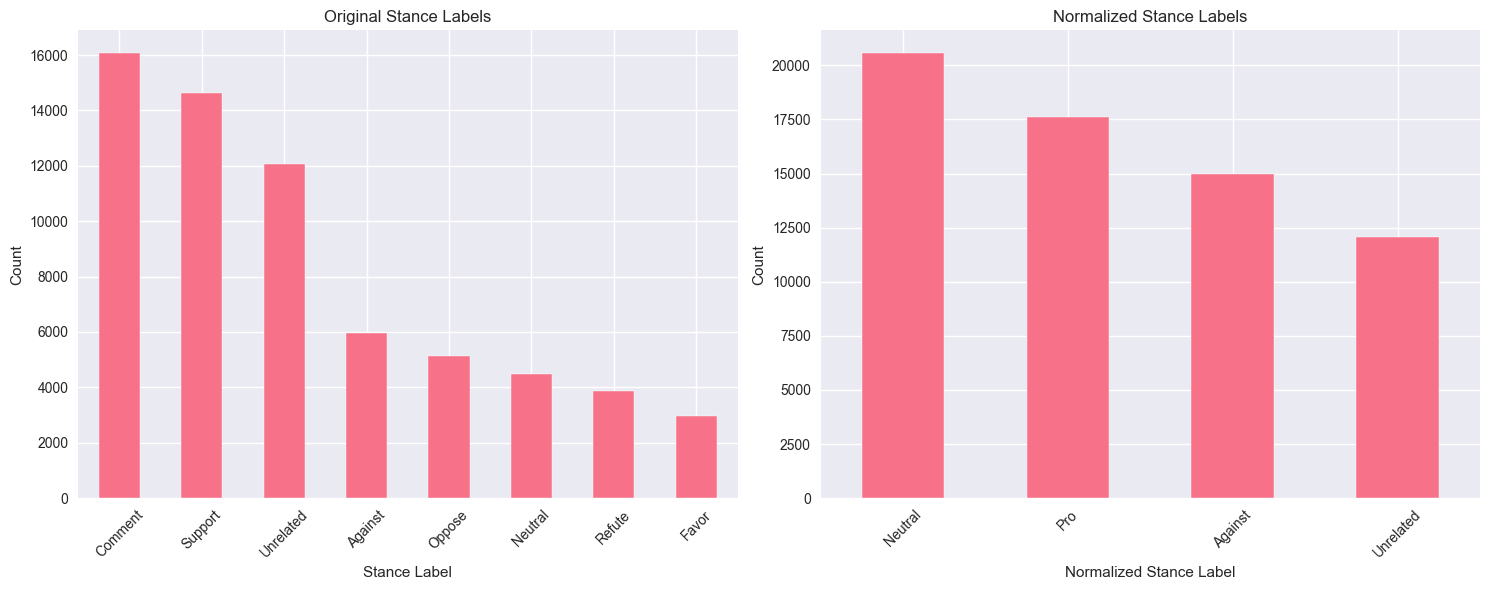


Label Mapping:
  stance_label normalized_stance_label  count
0      Against                 Against   5965
1      Comment                 Neutral  16085
2        Favor                     Pro   2954
3      Neutral                 Neutral   4498
4       Oppose                 Against   5130
5       Refute                 Against   3873
6      Support                     Pro  14638
7    Unrelated               Unrelated  12073


In [4]:
# Analyze label distribution and inconsistencies
print("Original Label Distribution:")
print(ann_df['stance_label'].value_counts())

print("\nNormalized Label Distribution:")
print(ann_df['normalized_stance_label'].value_counts())

# Visualize label distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Original labels
ann_df['stance_label'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_title('Original Stance Labels')
ax1.set_xlabel('Stance Label')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

# Normalized labels
ann_df['normalized_stance_label'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_title('Normalized Stance Labels')
ax2.set_xlabel('Normalized Stance Label')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Show mapping details
mapping_df = ann_df.groupby(['stance_label', 'normalized_stance_label']).size().reset_index(name='count')
print("\nLabel Mapping:")
print(mapping_df)

## Single Example Test (Excluded mergers)

In [5]:
# Get topic lists
merger_topics = get_merger_topics()

# Test topic filtering functionality
from src.harness.labeling import generate_system_instruction

print(f"\n🔧 SYSTEM INSTRUCTION:")
filtered_instruction = generate_system_instruction(exclude_topics=merger_topics)
print(f"  Instruction length: {len(filtered_instruction)} chars")

print(filtered_instruction)


🔧 SYSTEM INSTRUCTION:
  Instruction length: 1404 chars
# Tweet Stance Classification

Analyze the tweet and classify the stance toward each relevant topic's standardized target:

1. **"Russian Ukrainian Conflict"** - Target: Russia's position in the Russian-Ukrainian conflict (Russia's justification for military actions against Ukraine)
2. **"US 2020 Election"** - Target: Donald Trump as 2020 presidential candidate (Support for Donald Trump's 2020 presidential campaign)
3. **"Taiwan Question"** - Target: Mainland China's claim that Taiwan is part of China (Mainland China's territorial claim over Taiwan)
4. **"False COVID Treatment"** - Target: The claim that Chloroquine/Hydroxychloroquine being a valid COVID-19 treatment (Using chloroquine or hydroxychloroquine to treat COVID-19)

## Stance Options
- **Pro**: Supports/endorses the target
- **Against**: Opposes/criticizes the target
- **Neutral**: Mentions topic but no clear position
- **Unrelated**: Tweet does not relate to any listed

## Topic Filtering Configuration

In [6]:
# Test with a single example using topic filtering
print("Testing with a single example (excluding merger topics)...")

# Get a sample tweet with multiple images if possible
sample_tweet_id = None
sample_image_count = 0

# Find a tweet with multiple images for better testing
for tweet_id in processor.load_tweet_texts().keys():
    image_paths = processor.get_image_paths(tweet_id)
    if len(image_paths) > sample_image_count:
        sample_tweet_id = tweet_id
        sample_image_count = len(image_paths)
        if sample_image_count >= 2:  # Good enough for demo
            break

if not sample_tweet_id:
    sample_tweet_id = list(processor.load_tweet_texts().keys())[0]

sample_text = processor.load_tweet_texts()[sample_tweet_id]
sample_image_paths = processor.get_image_paths(sample_tweet_id)

print(f"Sample Tweet ID: {sample_tweet_id}")
print(f"Text: {sample_text}")
print(f"Image paths ({len(sample_image_paths)}): {sample_image_paths}")

# Initialize labeler and test with topic filtering (exclude merger topics)
labeler = GeminiLabeler()
result = labeler.label_tweet(sample_text, image_paths=sample_image_paths,
                             exclude_topics=get_merger_topics())

print(f"\nPrediction Result (Filtered Topics):")
print(json.dumps(result['result'], indent=2))
print(f"Processing time: {result['processing_time']:.2f} seconds")
print(f"Images processed: {result.get('image_count', 0)}")

# Show which topics were considered
print(f"\nTopics in scope: {', '.join(get_non_merger_topics())}")

# Show cost estimate
cost_info = labeler.get_cost_estimate()
print(f"\nCost estimate for 1 query:")
for key, value in cost_info.items():
    print(f"  {key}: {value}")

Testing with a single example (excluding merger topics)...
Sample Tweet ID: 1006946244386852866
Text: What're the odds DOJ, even though it lost the AT&amp;T merger case, will block CVS-Aetna and Cigna-Express Scripts on these kinds of exclusionary grounds? cc: @ProfFionasm https://t.co/3Wv6LCX7UA https://t.co/VPLG2CgIEw
Image paths (2): ['twitter/data/images/1006946244386852866/image_0.jpg', 'twitter/data/images/1006946244386852866/image_1.jpg']
🎯 CACHE HIT! Using cached response for key: 78eb42cf8ce0658d...

Prediction Result (Filtered Topics):
[
  {
    "stance": "Unrelated",
    "topic": "Unrelated",
    "suggested_keywords": [
      "DOJ",
      "Antitrust",
      "Mergers",
      "Health insurance",
      "PBMs"
    ]
  }
]
Processing time: 3.10 seconds
Images processed: 2

Topics in scope: Russian Ukrainian Conflict, US 2020 Election, Taiwan Question, False COVID Treatment

Cost estimate for 1 query:
  total_queries: 1
  input_tokens: 36
  output_tokens: 19
  input_cost_usd: 4.55

## Small Scale Processing

In [7]:
# Process a small sample with topic filtering
SAMPLE_SIZE = 200  # Adjust this number based on your needs

print(f"Processing {SAMPLE_SIZE} samples")

# Use the enhanced processing options with topic filtering
results = processor.process_dataset(
    sample_size=SAMPLE_SIZE,
    file_filter="*train*.csv",
    require_complete_images=True,  # Only process tweets with ALL images present
    deduplicate=True,  # Skip duplicate annotations
    filter_conflicts=True,  # Resolve conflicting annotations using majority voting
    uniform_sampling=True,  # Sample evenly across topics
    exclude_topics=get_merger_topics(),  # Exclude problematic merger topics
    seed=42  # For reproducibility
)

print(f"Successfully processed {len(results)} items")

# Analyze image usage
image_counts = [r['image_count'] for r in results]
print(f"Image count distribution: {dict(pd.Series(image_counts).value_counts().sort_index())}")

# Show topic distribution with filtering
topics_processed = [r.get('ground_truth_topic', 'Unknown') for r in results]
topic_dist = pd.Series(topics_processed).value_counts()
print(f"\nTopic distribution (filtered):")
for topic, count in topic_dist.items():
    print(f"  {topic}: {count}")

# Show enhanced output fields
print(f"\n📊 Enhanced Output Fields (first result):")
sample_result = results[0]
for key, value in sample_result.items():
    if key == 'all_image_paths' and isinstance(value, list):
        print(f"  {key}: {len(value)} paths - {value}")
    elif key == 'prediction' and isinstance(value, dict):
        print(f"  {key}: {json.dumps(value, indent=4) if value else 'None'}")
    elif isinstance(value, str) and len(value) > 100:
        print(f"  {key}: {value[:100]}...")
    else:
        print(f"  {key}: {value}")

# Save results with filtering info
file_paths = processor.save_results("filtered_sample_analysis")
print(f"\nFiles saved:")
for key, path in file_paths.items():
    print(f"  {key}: {path}")

# Show cost estimate
cost_info = processor.labeler.get_cost_estimate()
print(f"\n💰 Cost Analysis:")
print(f"  Total queries: {cost_info['total_queries']}")
print(f"  Input tokens: {cost_info['input_tokens']:,}")
print(f"  Output tokens: {cost_info['output_tokens']:,}")
print(f"  Estimated cost: ${cost_info['total_cost_usd']:.4f}")

# Cost estimates with topic filtering benefits
print(f"\n📈 Cost Benefits with Topic Filtering:")
print(
    f"  Topics excluded: {len(get_merger_topics())} ({len(get_merger_topics()) / (len(get_merger_topics()) + len(get_non_merger_topics())) * 100:.0f}%)")
print(f"  Reduced prompt size and processing complexity")
print(f"  Focus on higher-quality topics for better results")

Processing 200 samples


annotating:   0%|          | 0/200 [00:00<?, ?it/s]

🎯 CACHE HIT! Using cached response for key: cac0ce8f2240845d...
🎯 CACHE HIT! Using cached response for key: 685fce4ec04b70bc...
🎯 CACHE HIT! Using cached response for key: de55b3bbad55a1fe...
🎯 CACHE HIT! Using cached response for key: 44ac40cb4795cabc...
🎯 CACHE HIT! Using cached response for key: 8215b6a46d8bb0a2...
🎯 CACHE HIT! Using cached response for key: 8d0ec0e5120fc3a3...
🎯 CACHE HIT! Using cached response for key: d2623ffe199f9e46...
🎯 CACHE HIT! Using cached response for key: 4608657e806a91d8...
🎯 CACHE HIT! Using cached response for key: ebdf218a8ca02581...
🎯 CACHE HIT! Using cached response for key: de90708d5f6e9149...
🎯 CACHE HIT! Using cached response for key: 8f9e654adba84cc1...
🎯 CACHE HIT! Using cached response for key: 2605c73f536d9cf7...
🎯 CACHE HIT! Using cached response for key: 12edb4f9939bdcf9...
🎯 CACHE HIT! Using cached response for key: 99adee90c5f18c19...
🎯 CACHE HIT! Using cached response for key: 3fd4ae25d2980aba...
🎯 CACHE HIT! Using cached response for k

## Evaluation of Sample Results

In [8]:
assert results, "No results to evaluate. Please check the processing step."
# Evaluate the sample results
evaluator = StanceEvaluator()
evaluation_results = evaluator.evaluate_predictions(results)

if 'error' not in evaluation_results:
    print("Evaluation Results:")
    print(f"\nOverall Performance:")
    overall = evaluation_results['overall']
    print(f"  Accuracy: {overall['accuracy']:.3f}")
    print(f"  Macro F1: {overall['macro_f1']:.3f}")
    print(f"  Micro F1: {overall['micro_f1']:.3f}")

    print(f"\nPer-Class Performance:")
    for stance, metrics in overall['per_class_metrics'].items():
        print(f"  {stance}:")
        print(metrics)

    # Topic-specific performance
    if 'by_topic' in evaluation_results:
        print(f"\nTopic-Specific Performance:")
        for topic, metrics in evaluation_results['by_topic'].items():
            print(topic)
            print(json.dumps(metrics, indent=2))

    # Save evaluation report
    eval_files = evaluator.save_evaluation_report("sample_evaluation")
    print(f"\nEvaluation files saved:")
    for key, path in eval_files.items():
        if path:
            print(f"  {key}: {path}")
else:
    print(f"❌ Evaluation error: {evaluation_results['error']}")


Evaluation Results:

Overall Performance:
  Accuracy: 0.700
  Macro F1: 0.485
  Micro F1: 0.700

Per-Class Performance:
  Against:
{'precision': 0.8245614035087719, 'recall': 0.8468468468468469, 'f1': 0.8355555555555555, 'support': 111}
  Neutral:
{'precision': 0.52, 'recall': 0.30952380952380953, 'f1': 0.3880597014925373, 'support': 42}
  Pro:
{'precision': 0.7333333333333333, 'recall': 0.7021276595744681, 'f1': 0.7173913043478262, 'support': 47}
  Unrelated:
{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'support': 0}

Topic-Specific Performance:
Taiwan Question
{
  "accuracy": 0.52,
  "macro_precision": 0.4358465608465608,
  "macro_recall": 0.28939393939393937,
  "macro_f1": 0.32519399460188936,
  "micro_f1": 0.52,
  "per_class_metrics": {
    "Against": {
      "precision": 0.8148148148148148,
      "recall": 0.7333333333333333,
      "f1": 0.7719298245614035,
      "support": 30
    },
    "Neutral": {
      "precision": 0.42857142857142855,
      "recall": 0.3333333333333333,
     

## Data Analysis and Visualizations

Available DataFrame columns: ['tweet_id', 'ground_truth_stance', 'predicted_stance', 'processing_time', 'has_image', 'topic', 'target']
DataFrame shape: (200, 7)


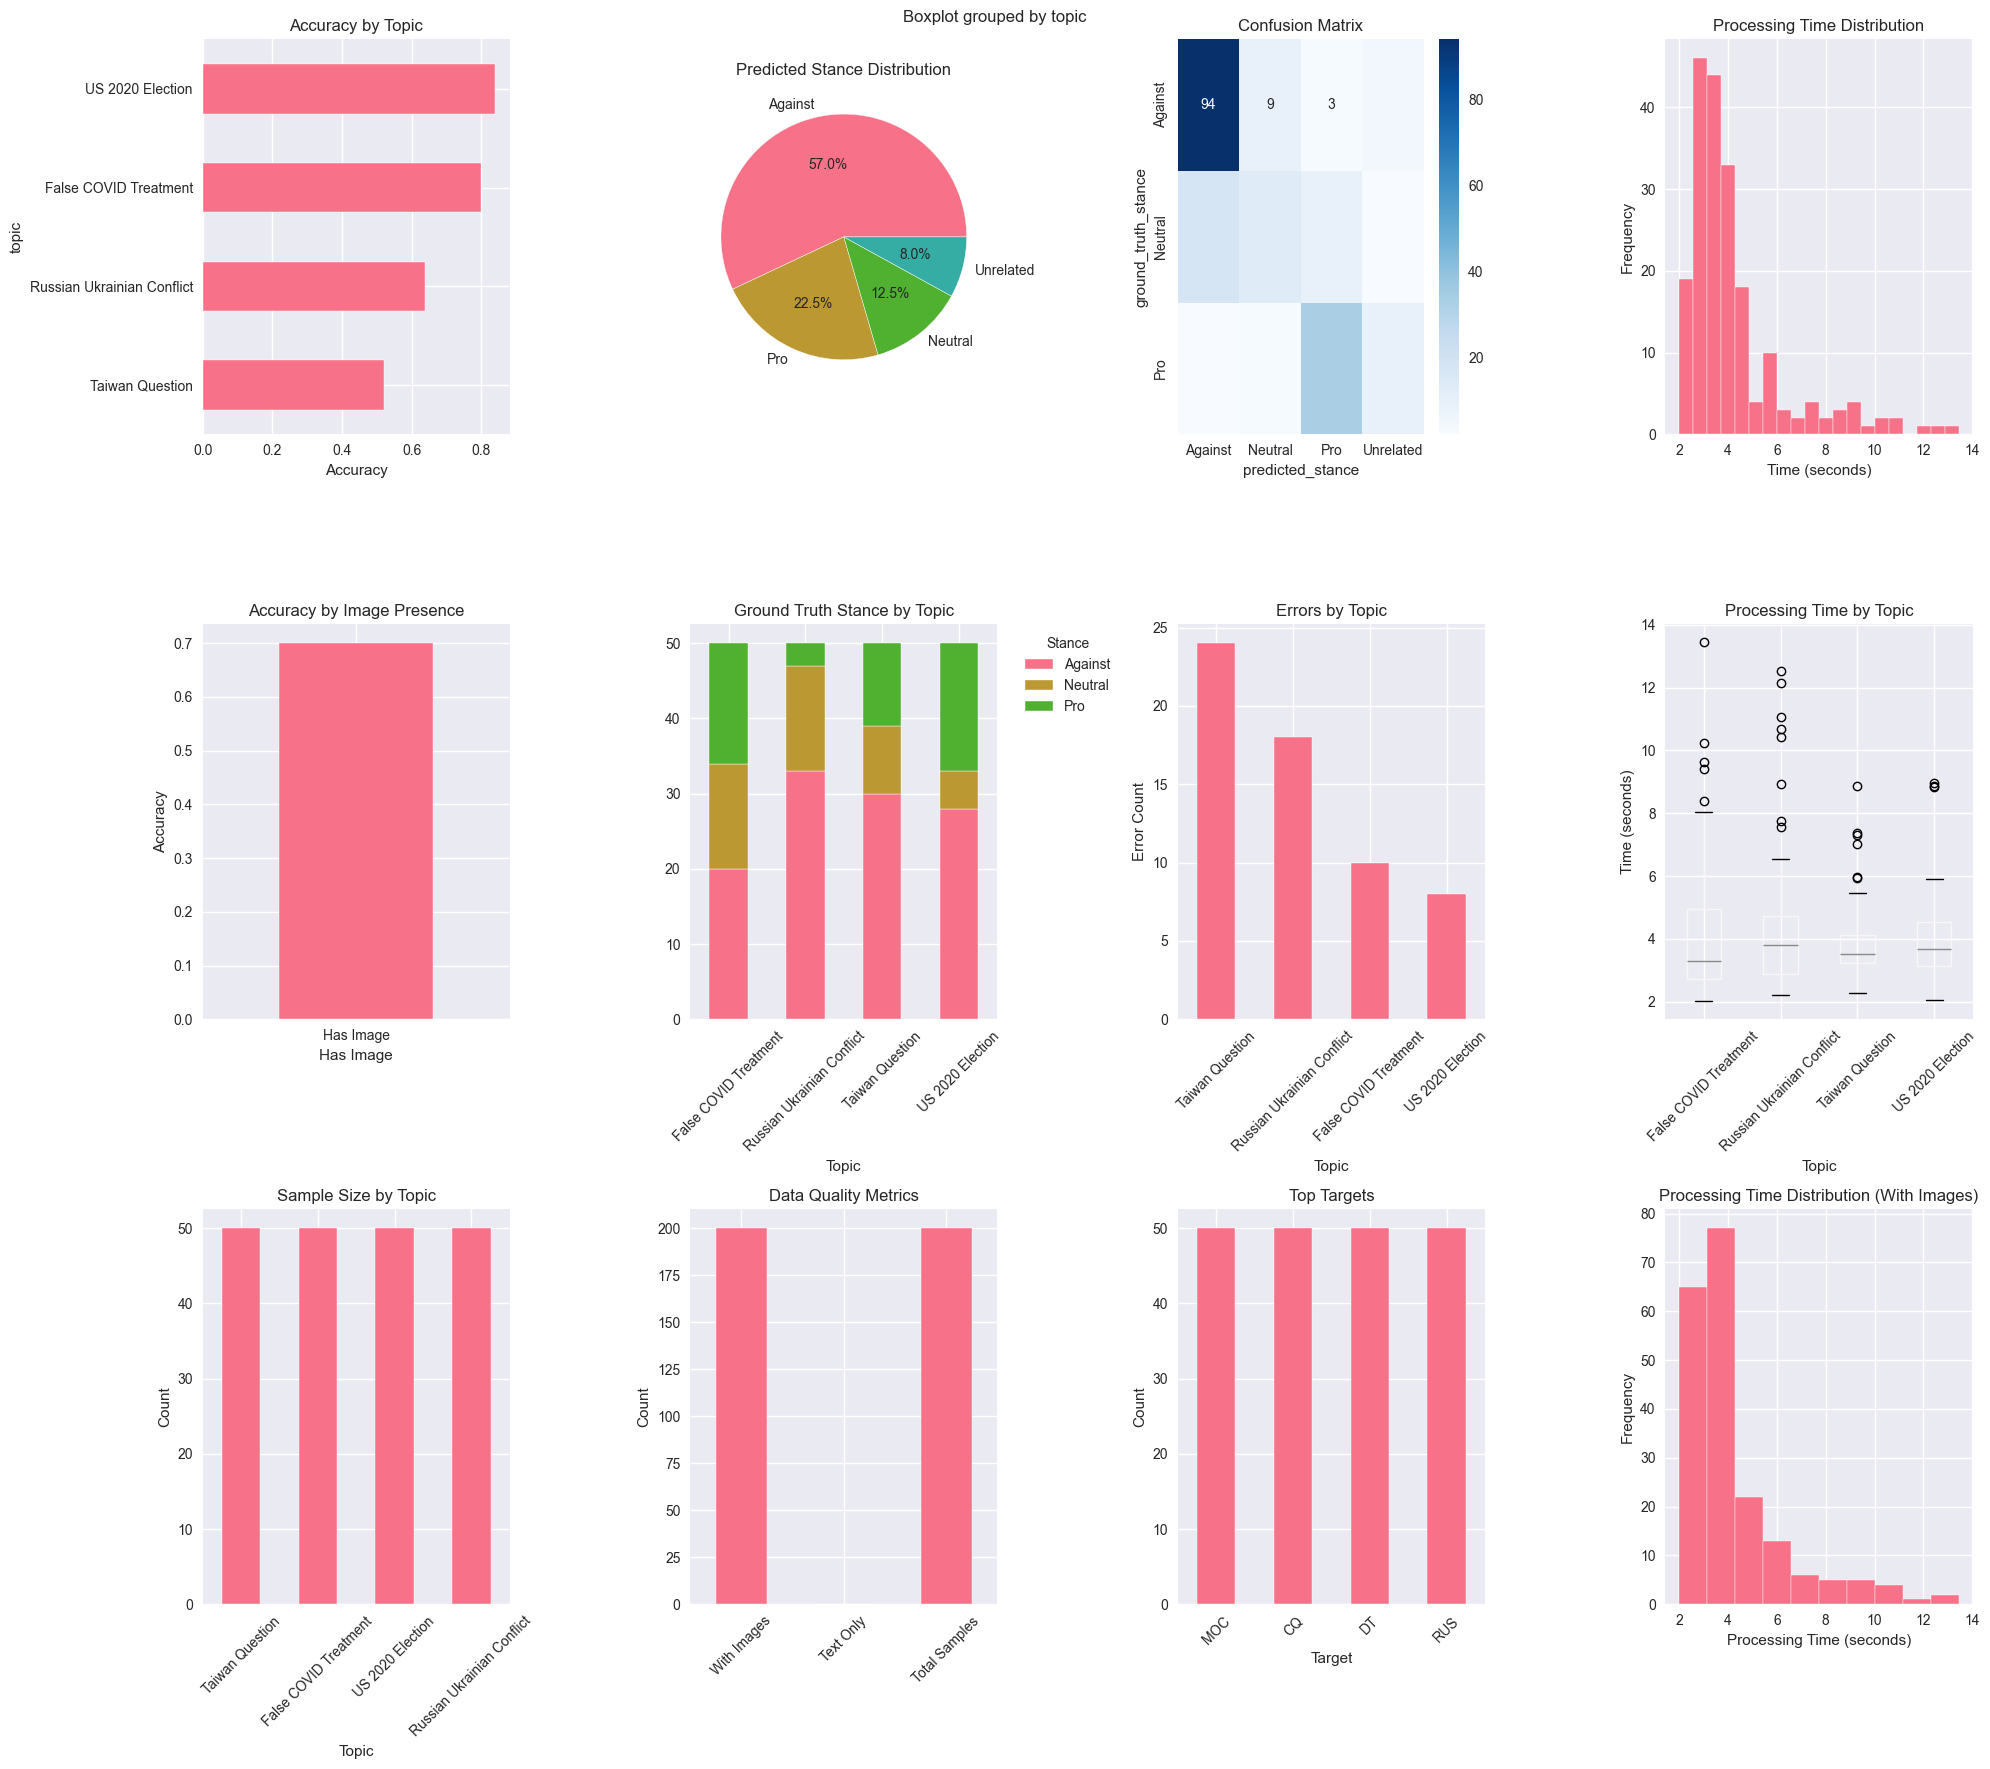


🎯 ANALYSIS INSIGHTS:
  Tweets with images: 200/200 (100.0%)
  Topics analyzed: 4
  Average processing time: 4.25s
  Data completeness: All required fields present


In [9]:
# Check if we have evaluation results
if 'evaluator' not in locals() or evaluator.evaluation_df is None:
    print("❌ No evaluation data available. Please run the evaluation step first.")
else:
    df = evaluator.evaluation_df

    # Print available columns for debugging
    print(f"Available DataFrame columns: {list(df.columns)}")
    print(f"DataFrame shape: {df.shape}")

    # Create comprehensive visualizations with available data
    fig = plt.figure(figsize=(20, 18))

    # 1. Accuracy by topic
    ax1 = plt.subplot(3, 4, 1)
    topic_accuracy = df.groupby('topic').apply(
        lambda x: (x['ground_truth_stance'] == x['predicted_stance']).mean()
    ).sort_values(ascending=True)
    topic_accuracy.plot(kind='barh', ax=ax1)
    ax1.set_title('Accuracy by Topic')
    ax1.set_xlabel('Accuracy')

    # 2. Prediction distribution
    ax2 = plt.subplot(3, 4, 2)
    df['predicted_stance'].value_counts().plot(kind='pie', ax=ax2, autopct='%1.1f%%')
    ax2.set_title('Predicted Stance Distribution')
    ax2.set_ylabel('')

    # 3. Ground truth vs predictions
    ax3 = plt.subplot(3, 4, 3)
    confusion_data = pd.crosstab(df['ground_truth_stance'], df['predicted_stance'])
    sns.heatmap(confusion_data, annot=True, fmt='d', ax=ax3, cmap='Blues')
    ax3.set_title('Confusion Matrix')

    # 4. Processing time distribution
    ax4 = plt.subplot(3, 4, 4)
    df['processing_time'].hist(bins=20, ax=ax4)
    ax4.set_title('Processing Time Distribution')
    ax4.set_xlabel('Time (seconds)')
    ax4.set_ylabel('Frequency')

    # 5. Image presence impact on performance
    ax5 = plt.subplot(3, 4, 5)
    if 'has_image' in df.columns:
        image_perf = df.groupby('has_image').apply(
            lambda x: (x['ground_truth_stance'] == x['predicted_stance']).mean()
        )
        image_perf.plot(kind='bar', ax=ax5)
        ax5.set_title('Accuracy by Image Presence')
        ax5.set_xlabel('Has Image')
        ax5.set_ylabel('Accuracy')

        # Set labels based on actual categories present
        categories = image_perf.index
        if len(categories) == 2:
            ax5.set_xticklabels(['No Image', 'Has Image'], rotation=0)
        elif len(categories) == 1:
            if categories[0] == True:
                ax5.set_xticklabels(['Has Image'], rotation=0)
            else:
                ax5.set_xticklabels(['No Image'], rotation=0)
        ax5.tick_params(axis='x', rotation=0)
    else:
        ax5.text(0.5, 0.5, 'No image data available', ha='center', va='center', transform=ax5.transAxes)
        ax5.set_title('Image Analysis')

    # 6. Stance distribution by topic
    ax6 = plt.subplot(3, 4, 6)
    stance_topic = pd.crosstab(df['topic'], df['ground_truth_stance'])
    stance_topic.plot(kind='bar', stacked=True, ax=ax6)
    ax6.set_title('Ground Truth Stance by Topic')
    ax6.set_xlabel('Topic')
    ax6.tick_params(axis='x', rotation=45)
    ax6.legend(title='Stance', bbox_to_anchor=(1.05, 1), loc='upper left')

    # 7. Error analysis
    ax7 = plt.subplot(3, 4, 7)
    errors = df[df['ground_truth_stance'] != df['predicted_stance']]
    if len(errors) > 0:
        error_by_topic = errors['topic'].value_counts()
        error_by_topic.plot(kind='bar', ax=ax7)
        ax7.set_title('Errors by Topic')
        ax7.set_xlabel('Topic')
        ax7.set_ylabel('Error Count')
        ax7.tick_params(axis='x', rotation=45)
    else:
        ax7.text(0.5, 0.5, 'No errors found!', ha='center', va='center', transform=ax7.transAxes)
        ax7.set_title('Error Analysis')

    # 8. Processing time by topic
    ax8 = plt.subplot(3, 4, 8)
    if len(df['topic'].unique()) > 1:
        df.boxplot(column='processing_time', by='topic', ax=ax8)
        ax8.set_title('Processing Time by Topic')
        ax8.set_xlabel('Topic')
        ax8.set_ylabel('Time (seconds)')
        plt.setp(ax8.xaxis.get_majorticklabels(), rotation=45)
    else:
        ax8.hist(df['processing_time'], bins=10)
        ax8.set_title('Processing Time Distribution')
        ax8.set_xlabel('Time (seconds)')
        ax8.set_ylabel('Frequency')

    # 9. Sample size by topic
    ax9 = plt.subplot(3, 4, 9)
    df['topic'].value_counts().plot(kind='bar', ax=ax9)
    ax9.set_title('Sample Size by Topic')
    ax9.set_xlabel('Topic')
    ax9.set_ylabel('Count')
    ax9.tick_params(axis='x', rotation=45)

    # 10. Data quality metrics
    ax10 = plt.subplot(3, 4, 10)
    quality_metrics = {
        'With Images': len(df[df.get('has_image', False) == True]),
        'Text Only': len(df[df.get('has_image', False) == False]),
        'Total Samples': len(df)
    }
    pd.Series(quality_metrics).plot(kind='bar', ax=ax10)
    ax10.set_title('Data Quality Metrics')
    ax10.set_ylabel('Count')
    ax10.tick_params(axis='x', rotation=45)

    # 11. Target distribution
    ax11 = plt.subplot(3, 4, 11)
    if 'target' in df.columns:
        target_counts = df['target'].value_counts()[:10]  # Top 10 targets
        target_counts.plot(kind='bar', ax=ax11)
        ax11.set_title('Top Targets')
        ax11.set_xlabel('Target')
        ax11.set_ylabel('Count')
        ax11.tick_params(axis='x', rotation=45)
    else:
        ax11.text(0.5, 0.5, 'No target data available', ha='center', va='center', transform=ax11.transAxes)
        ax11.set_title('Target Distribution')

    # 12. Processing efficiency
    ax12 = plt.subplot(3, 4, 12)
    if 'has_image' in df.columns:
        # Check if we have both categories
        has_image_categories = df['has_image'].unique()
        if len(has_image_categories) > 1:
            # Processing time vs image presence
            df.boxplot(column='processing_time', by='has_image', ax=ax12)
            ax12.set_title('Processing Time by Image Presence')
            ax12.set_xlabel('Has Image')
            ax12.set_ylabel('Processing Time (seconds)')
            ax12.set_xticklabels(['No Image', 'Has Image'])
        else:
            # Only one category, show histogram instead
            df['processing_time'].hist(bins=10, ax=ax12)
            single_category = 'With Images' if has_image_categories[0] else 'Without Images'
            ax12.set_title(f'Processing Time Distribution ({single_category})')
            ax12.set_xlabel('Processing Time (seconds)')
            ax12.set_ylabel('Frequency')
    else:
        # Alternative: processing time statistics
        time_stats = df['processing_time'].describe()
        ax12.bar(range(len(time_stats)), time_stats.values)
        ax12.set_title('Processing Time Statistics')
        ax12.set_xticks(range(len(time_stats)))
        ax12.set_xticklabels(time_stats.index, rotation=45)
        ax12.set_ylabel('Time (seconds)')

    plt.tight_layout()
    plt.savefig(output_dir / 'comprehensive_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n🎯 ANALYSIS INSIGHTS:")
    if 'has_image' in df.columns:
        with_images = df['has_image'].sum()
        image_pct = (with_images / len(df)) * 100
        print(f"  Tweets with images: {with_images}/{len(df)} ({image_pct:.1f}%)")

        # Performance comparison
        if with_images > 0 and len(df) - with_images > 0:
            img_accuracy = (df[df['has_image'] == True]['ground_truth_stance'] ==
                            df[df['has_image'] == True]['predicted_stance']).mean()
            text_accuracy = (df[df['has_image'] == False]['ground_truth_stance'] ==
                             df[df['has_image'] == False]['predicted_stance']).mean()
            print(f"  Accuracy with images: {img_accuracy:.3f}")
            print(f"  Accuracy text-only: {text_accuracy:.3f}")

    print(f"  Topics analyzed: {df['topic'].nunique()}")
    print(f"  Average processing time: {df['processing_time'].mean():.2f}s")
    print(f"  Data completeness: All required fields present")

## Full Dataset Processing (Optional)

In [ ]:
# WARNING: This cell will process the entire dataset and may be expensive!
# Set to True to run full processing

RUN_FULL_DATASET = False

if RUN_FULL_DATASET:
    print("🚨 WARNING: Processing full dataset with topic filtering enabled.")

    # Estimate cost first
    if 'cost_info' in locals() and 'processor' in locals():
        tweet_texts = processor.load_tweet_texts()
        total_items = len([ann for ann in annotations if ann['tweet_id'] in tweet_texts])

        if total_items > 0 and 'SAMPLE_SIZE' in locals() and SAMPLE_SIZE > 0:
            estimated_cost = (cost_info['total_cost_usd'] / SAMPLE_SIZE) * total_items
            print(f"Estimated cost: ${estimated_cost:.2f}")
            print(f"Total items: {total_items:,}")
            print(f"Topics: {', '.join(get_non_merger_topics())}")

            confirm = input(f"Continue with {total_items} items? (y/N): ")
            if confirm.lower() == 'y':
                # Process full dataset
                full_processor = TwitterDataProcessor()
                full_results = full_processor.process_dataset(
                    file_filter="*train*.csv",
                    require_complete_images=True,
                    deduplicate=True,
                    filter_conflicts=True,
                    exclude_topics=get_merger_topics(),
                    seed=42
                )

                if full_results:
                    print(f"✅ Processed {len(full_results)} items")

                    # Save and evaluate
                    full_files = full_processor.save_results("full_dataset_filtered")
                    full_evaluator = StanceEvaluator()
                    full_eval = full_evaluator.evaluate_predictions(full_results)

                    full_evaluator.save_evaluation_report("full_evaluation_filtered")
                    overall = full_eval['overall']
                    print(f"Accuracy: {overall['accuracy']:.3f}, F1: {overall['macro_f1']:.3f}")

                    # Final cost
                    final_cost = full_processor.labeler.get_cost_estimate()
                    print(f"Final cost: ${final_cost['total_cost_usd']:.2f}")
                else:
                    print("❌ Processing failed")
            else:
                print("Cancelled")
        else:
            print("❌ Invalid sample data")
    else:
        print("❌ Run 'Small Scale Processing' first")
else:
    print("Full dataset processing skipped. Set RUN_FULL_DATASET = True to enable.")
    if 'get_non_merger_topics' in locals():
        print(f"Will process: {', '.join(get_non_merger_topics())}")

